Se carga el modelo en memoria y se cargan los pesos del mejor modelo guardado durante el entrenamiento, que será el que ha conseguido un menor error de validación. De forma opcional también se pueden cargar los pesos del último modelo guardado durante el entrenamiento.

Después de esto se pone en modo evaluación para que no calcule los gradientes ya que no se va a hacer entrenamiento.

In [1]:
from models import UNet3D, MiniUNet3D
import torch

MODEL_NAME = 'sistema_5_normalizacion'
FILENAME = MODEL_NAME + '.pth'
train_on_gpu = torch.cuda.is_available()

#model = MiniUNet3D(1,2)
model = UNet3D(1,2)
if train_on_gpu:
    model.cuda()
model.load_state_dict(torch.load(FILENAME)['best_model_state_dict'])
# Descomentar la línea de abajo para usar los últimos pesos del modelo, independientemente del error de valid.
#model.load_state_dict(torch.load(FILENAME)['model_state_dict'])

model.eval()

UNet3D(
  (ec0): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): ReLU()
  )
  (ec1): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): ReLU()
  )
  (ec2): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): ReLU()
  )
  (ec3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): ReLU()
  )
  (ec4): Sequential(
    (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): ReLU()
  )
  (ec5): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): ReLU()
  )
  (ec6): Sequential(
    (0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): ReLU()
  )
  (ec7): Sequential(
    (0

Se cargan los datos a los que hacer la inferencia

In [5]:
from dataset import CellsDataset, PATHS
from torchvision import transforms
import torchio.transforms as transformsio

# Ruta a la carpeta donde se encuentran las imágenes a las que hacer inferencia.
TEST_PATH = PATHS['LQ_TEST']
# target: Segmentación con espacio entre células. boundaries: Bordes de las células.
# not_segmented_target: Segmentación sin espaciado entre células.
MODE = 'target'

transform = transforms.Compose([transformsio.ZNormalization()])
data = CellsDataset(TEST_PATH, target_mode=MODE, transform=transform)

Compara la imagen original con el etiquetado perfecto y con la predicción del modelo.

Matriz de confusión por clases:
 tensor([[0.9901, 0.1560],
        [0.0099, 0.8440]])
mean IoU:
 tensor([0.9811, 0.7224])
Células etiquetado original:
 [54] 
 Células etiquetado reescalado: 
 [55]
 Células predicción:
 [46, 38]
-------------------
Células etiquetado original: [60]	 Células etiquetado reescalado: [60] 	 Células predicción: 38
Matriz de confusión por clases de esta imagen: 
tensor([[[0.9905, 0.1711],
         [0.0095, 0.8289]]])
IoU de esta imagen: 
tensor([[0.9805, 0.7144]])


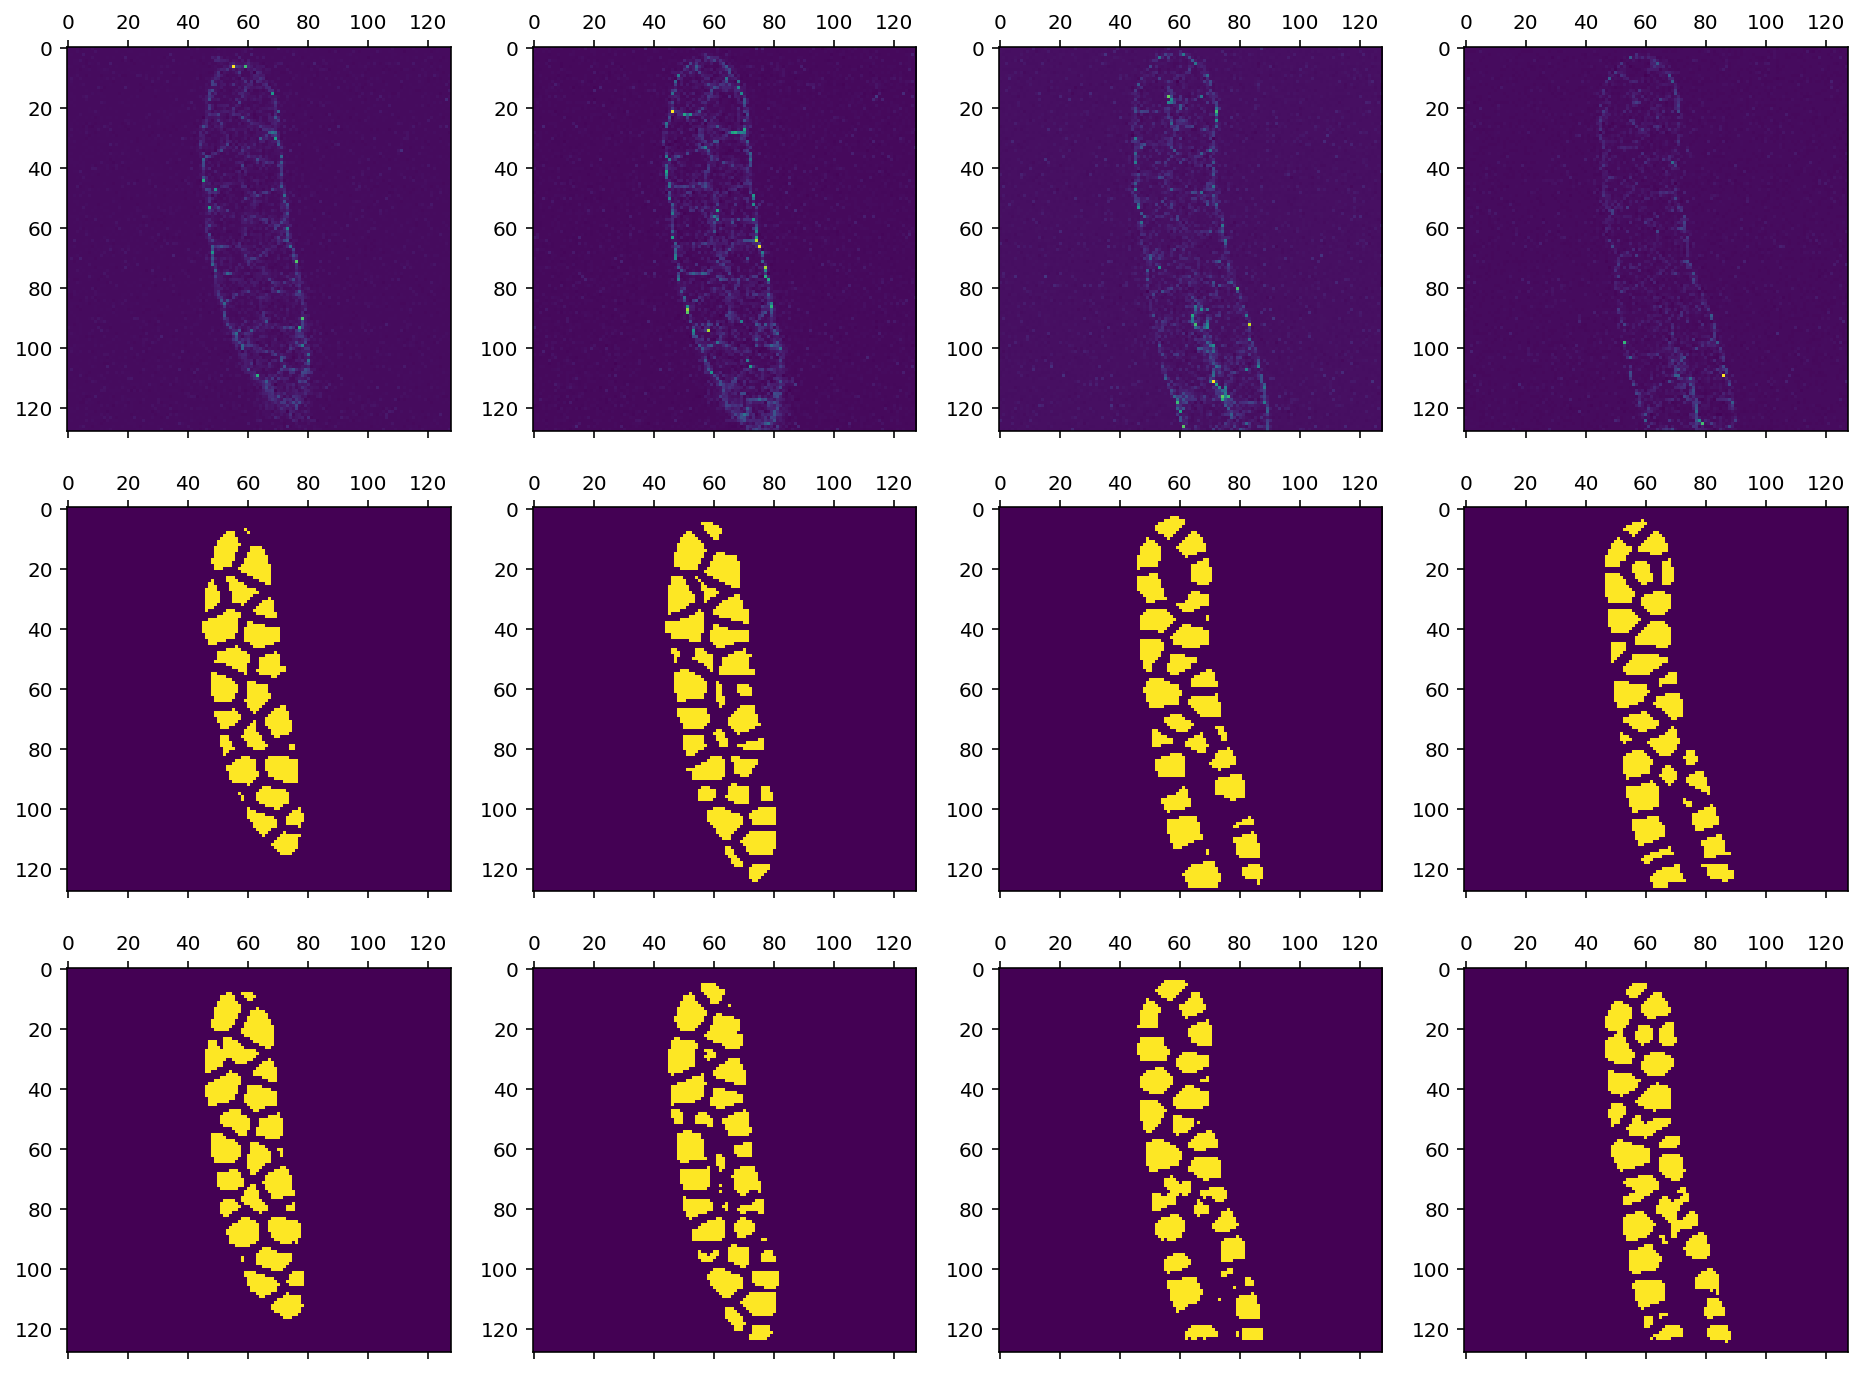

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from utils import metrics, compare_output
metrics(model, data)
print('-------------------')
pred, output = compare_output(model, 1, data, [20, 25, 45, 50])

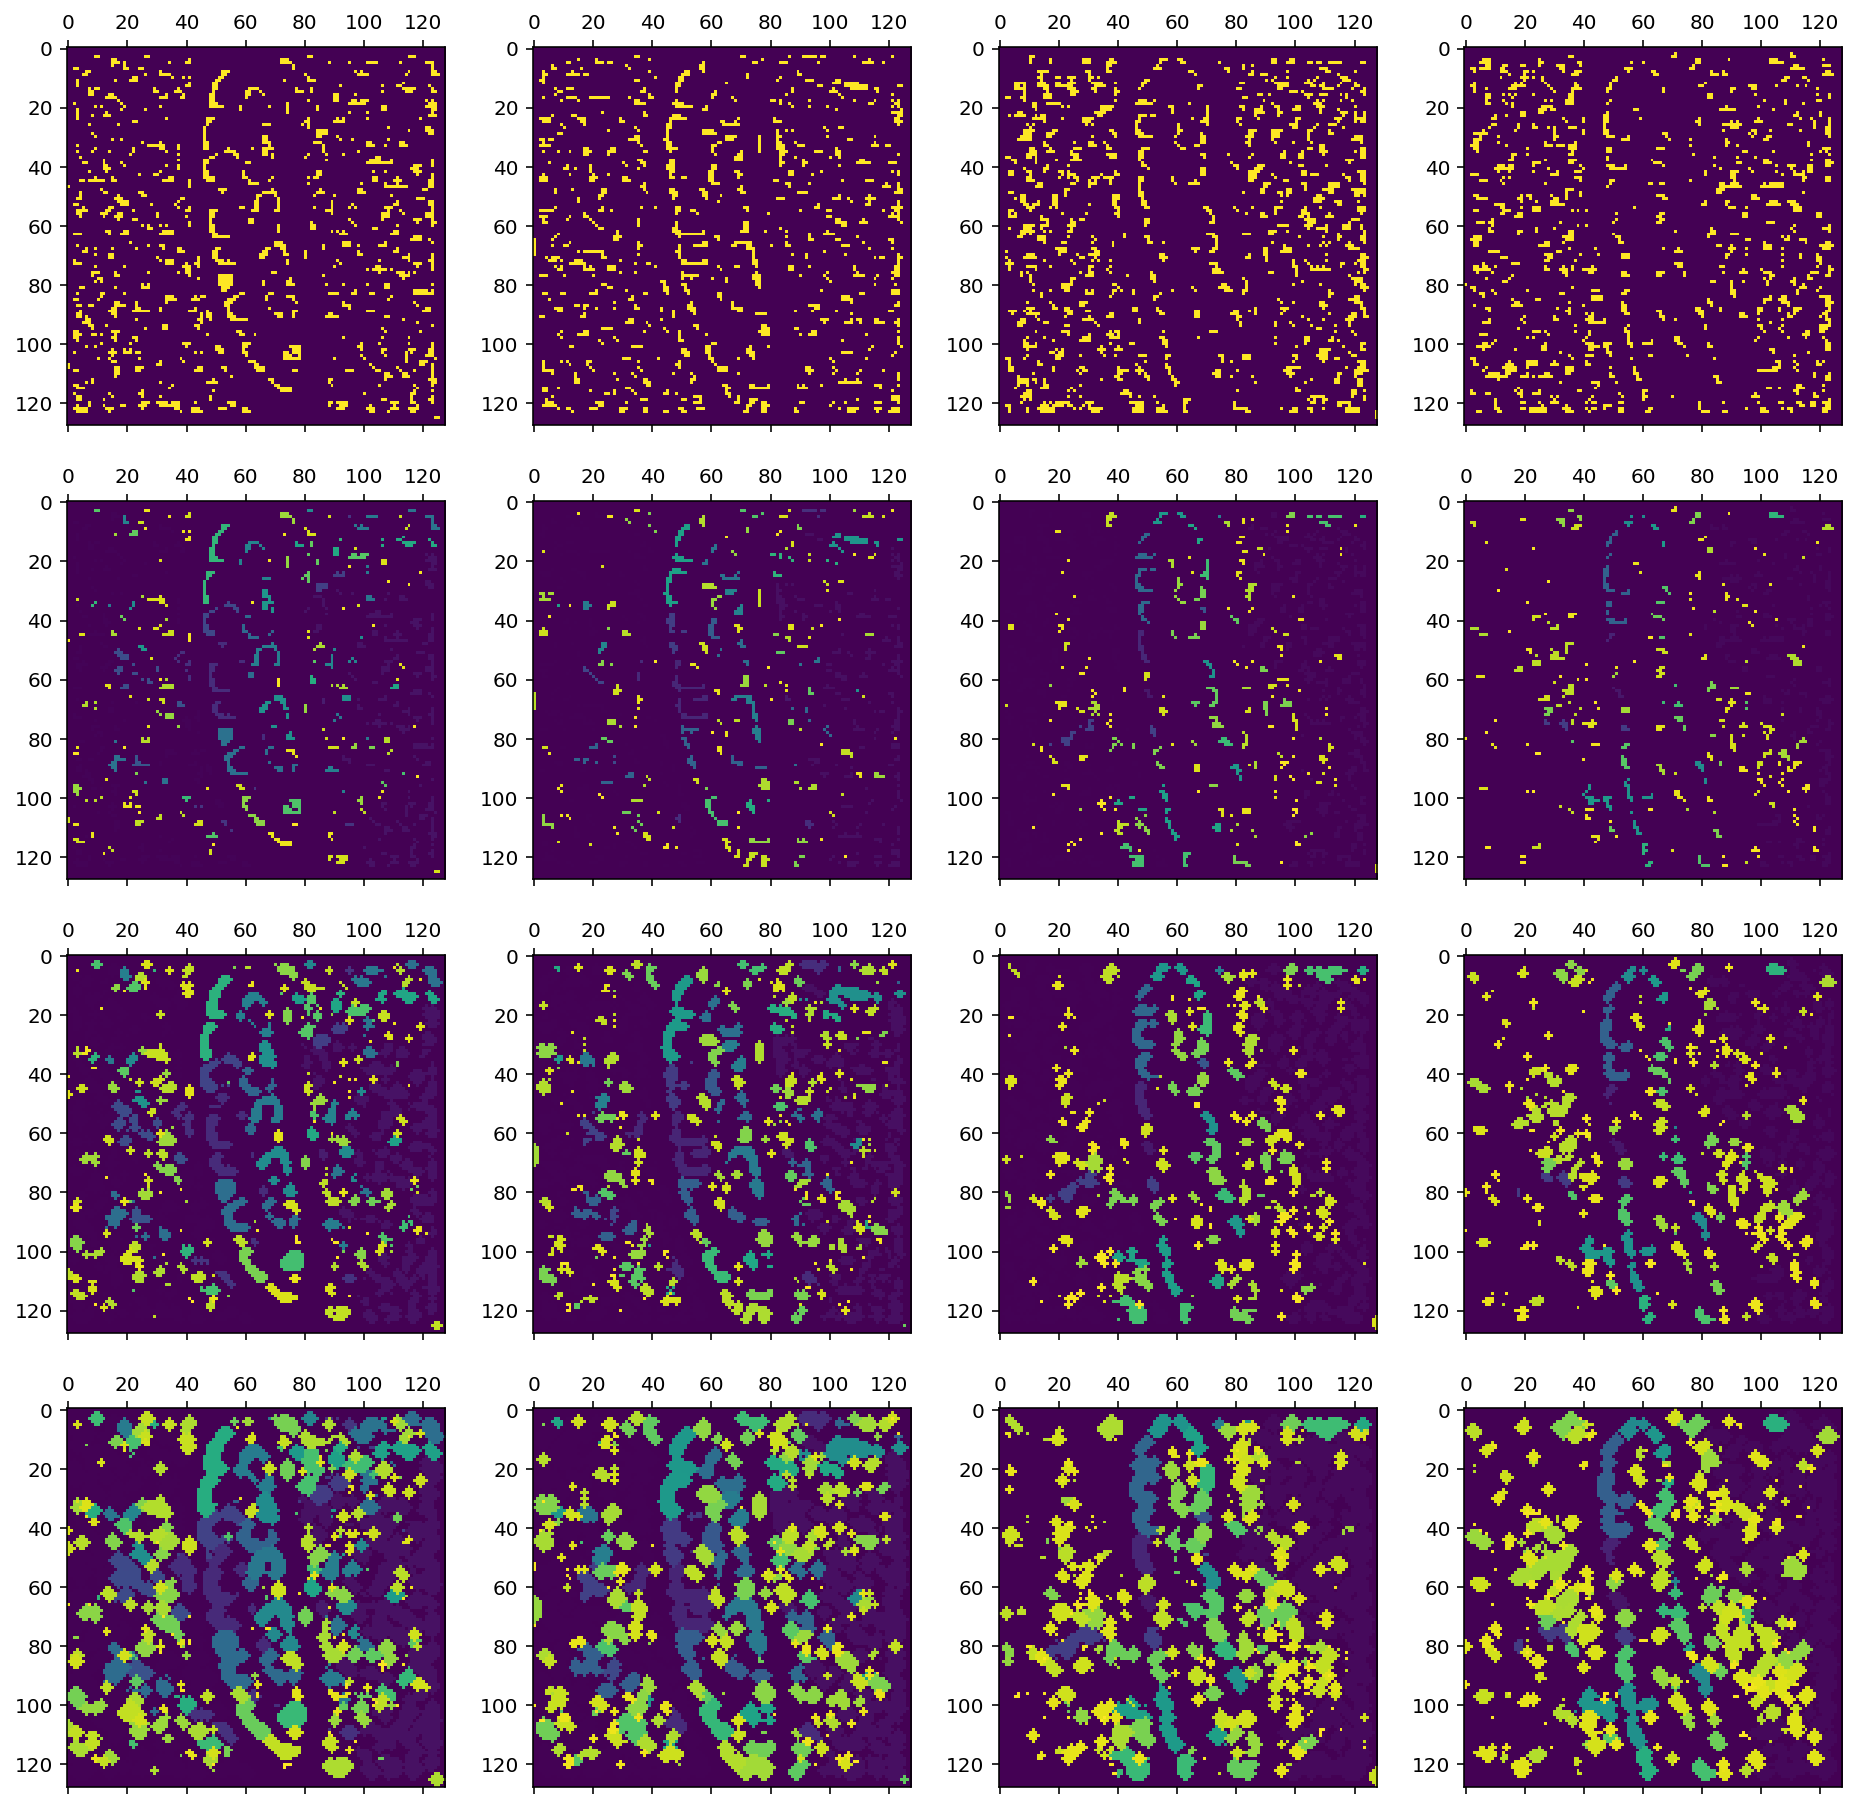

In [6]:
from utils import draw_images
from skimage import measure
from skimage.morphology import dilation
colored = measure.label(pred[0], return_num=False)
draw_images([pred[0], colored, dilation(colored) ,dilation(dilation(colored))], [20, 25, 45, 50])

## DT Watershed (needs border prediction)

In [7]:
import numpy as np
from scipy import ndimage as ndi
from skimage.filters import gaussian
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
distance = ndi.distance_transform_edt(pred[0])
distance_gaussian = gaussian(distance, sigma=2)
local_maxi = peak_local_max(-distance_gaussian, indices=False, labels=np.array(1-pred[0]))
markers = ndi.label(local_maxi)[0]
labels = watershed(distance_gaussian, markers, mask=1-pred[0])

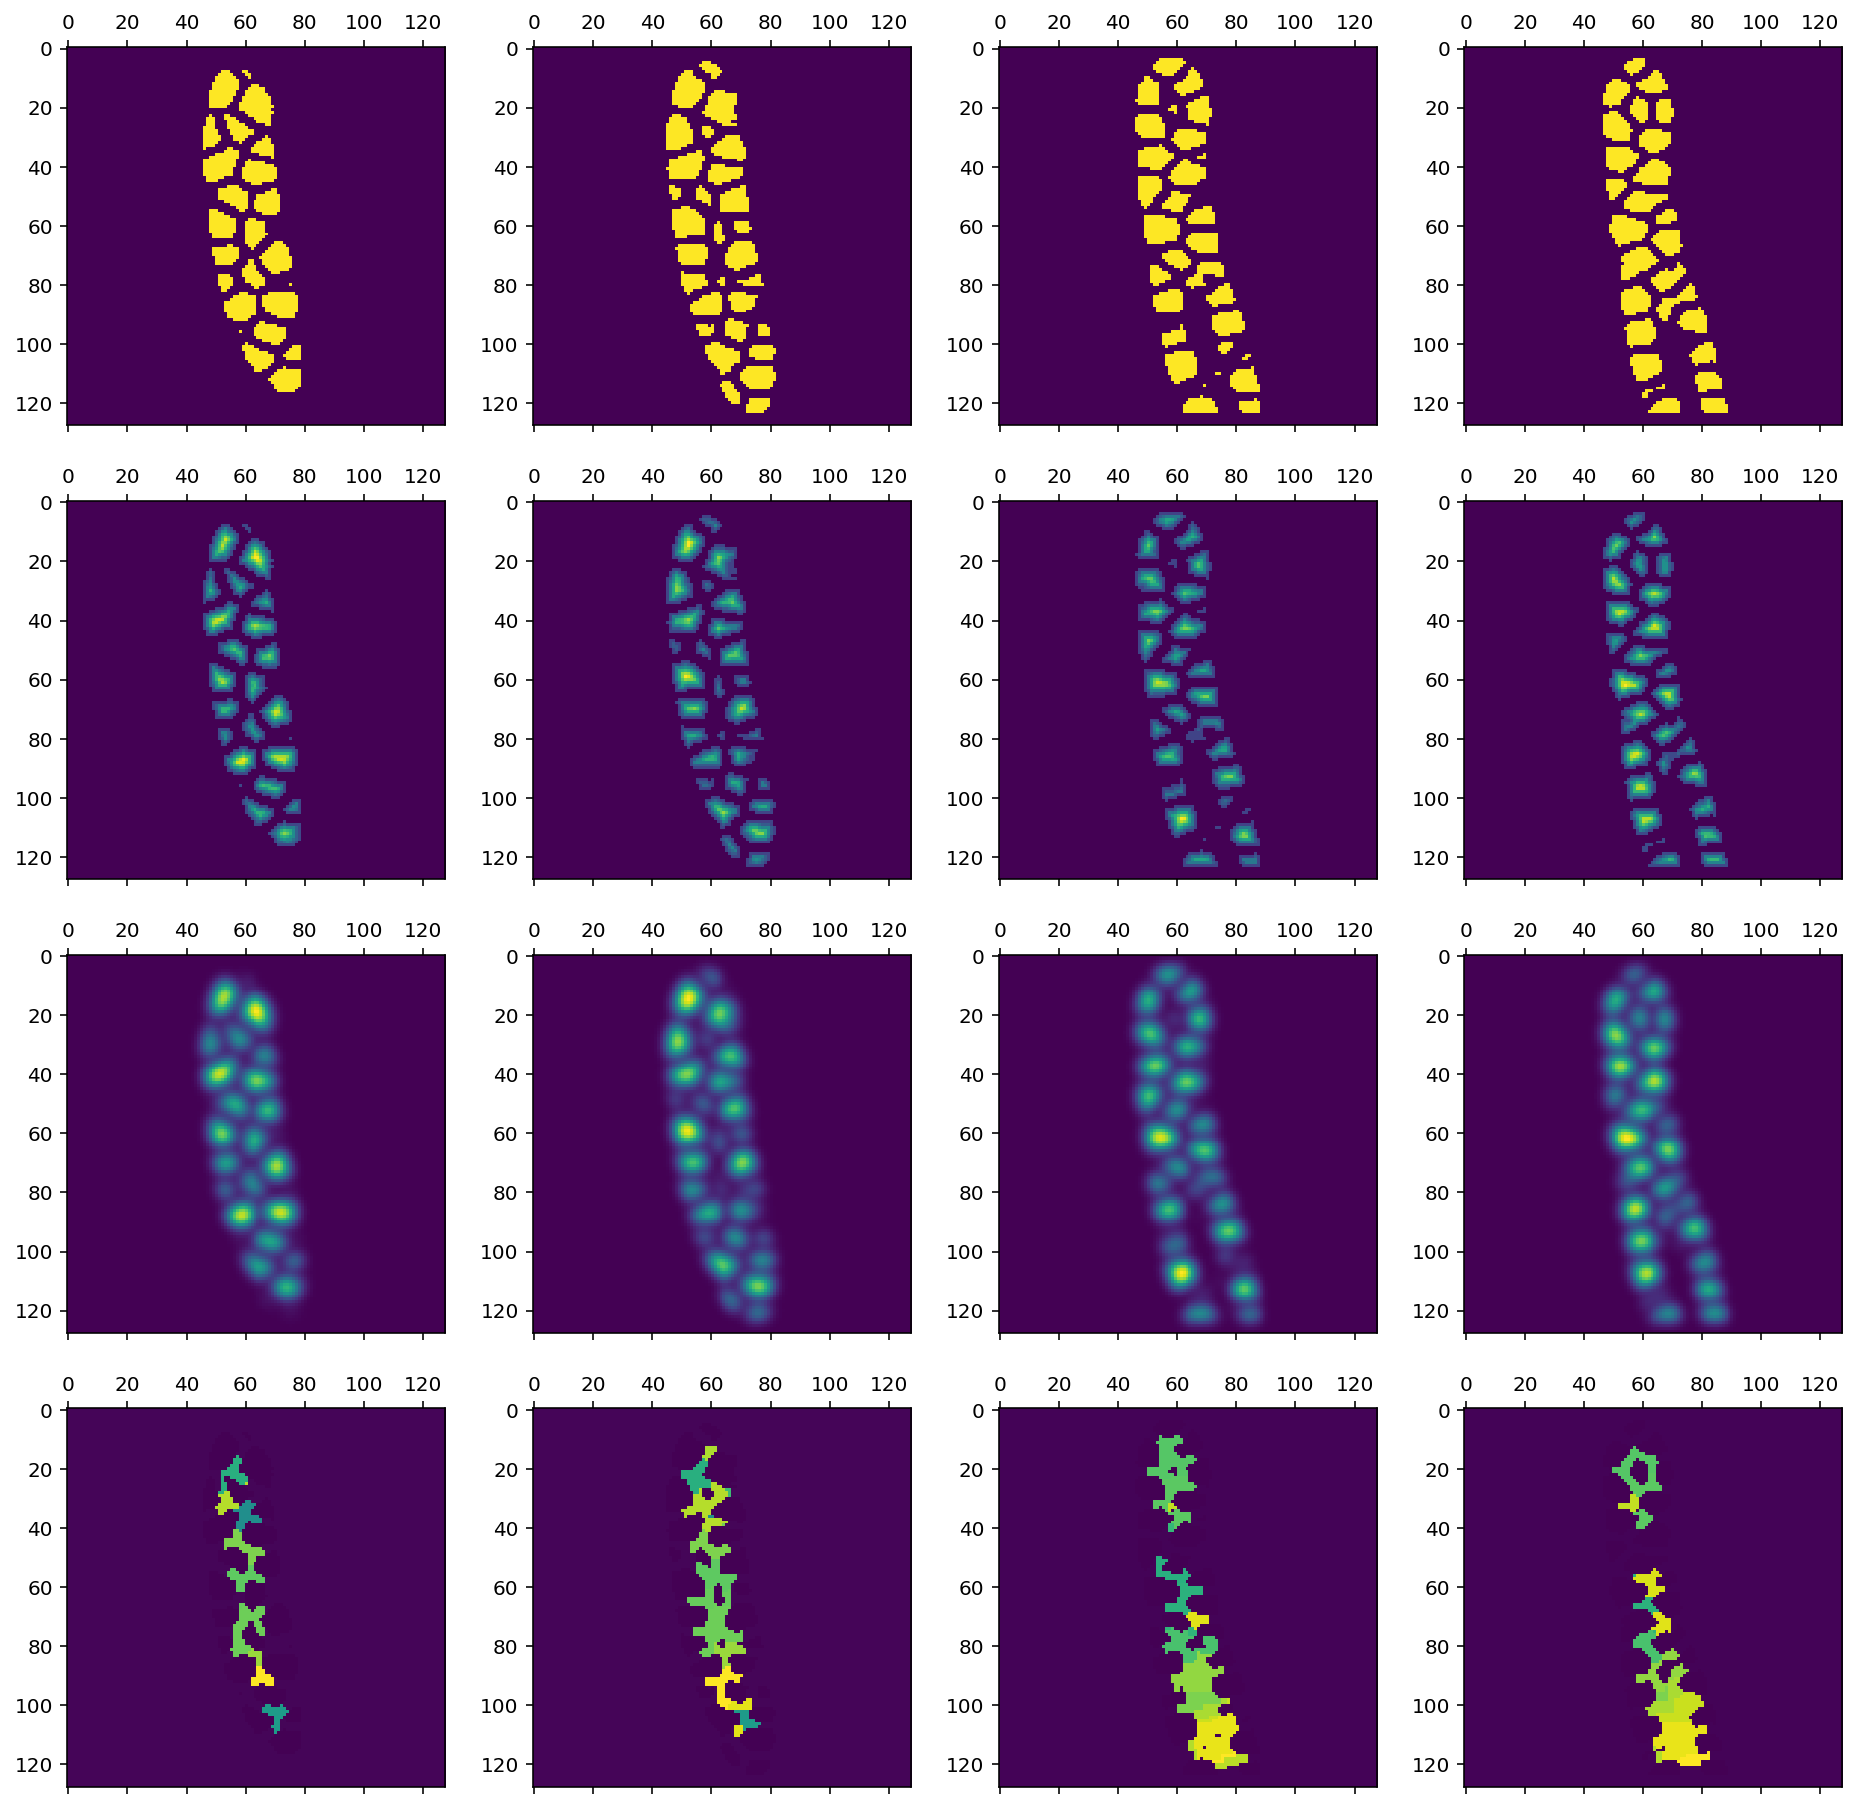

In [8]:
from utils import draw_images
draw_images([pred[0], distance, distance_gaussian, labels-1], [20, 25, 45, 50])

## Pérdidas de Entrenamiento y validación

Mejor valor de validación: 0.19089040160179138	 Valor de entrenamiento: 0.14786943594614665	 iteracion: 89
 Último valor de validación: 0.19669854640960693	 Valor de entrenamiento: 0.1611379067103068	 iteracion: 99


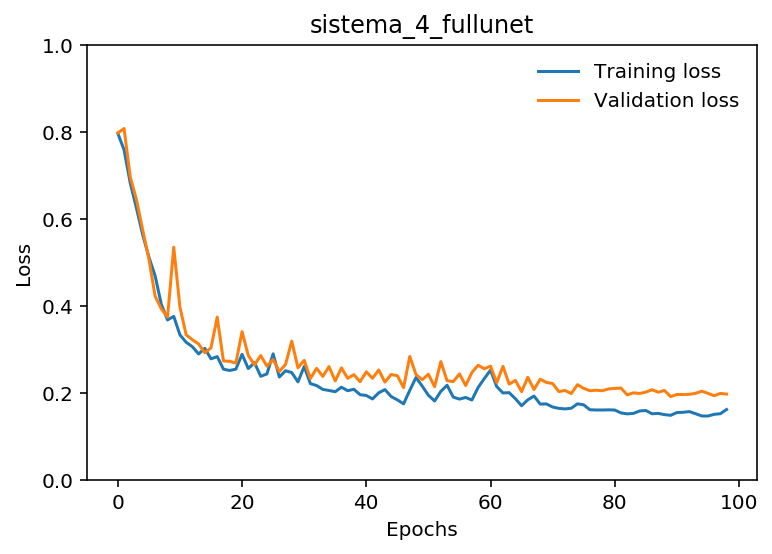

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from utils import plot_epochs
train_losses = torch.load(FILENAME)['train_losses']
valid_losses = torch.load(FILENAME)['valid_losses']
train_losses = train_losses[:99]
valid_losses = valid_losses[:99]
plot_epochs(train_losses, valid_losses, MODEL_NAME)
